In [1]:
import numpy as np
import pickle

In [2]:
from pathlib import Path
from abc import ABC, abstractmethod

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm import tqdm
import matplotlib.pyplot as plt

from cc_hardware.utils.manager import Manager
from cc_hardware.utils.file_handlers import PklReader
from cc_hardware.utils import register_cli, run_cli
from cc_hardware.utils import get_logger

from cc_hardware.algos.datasets import HistogramDataset
from cc_hardware.algos.models import DeepLocation8, initialize_weights

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [3]:
dataset_path = "../../datasets/classification-demo/training_2/zero.pkl"
dataset_0 = HistogramDataset(
    dataset_path,
    rolling_window=5
)
dataset_path = "../../datasets/classification-demo/training_2/zone_1.pkl"
dataset_1 = HistogramDataset(
    dataset_path,
    rolling_window=5
)
dataset_path = "../../datasets/classification-demo/training_2/zone_2.pkl"
dataset_2 = HistogramDataset(
    dataset_path,
    rolling_window=5
)
dataset_path = "../../datasets/classification-demo/training_2/zone_3.pkl"
dataset_3 = HistogramDataset(
    dataset_path,
    rolling_window=5
)

In [4]:
for dataset in [dataset_0, dataset_1, dataset_2, dataset_3]:
    dataset.raw_inputs = dataset.raw_inputs[:1000]
    dataset.raw_targets = dataset.raw_targets[:1000]
    dataset.inputs = dataset.raw_inputs
    dataset.targets = dataset.raw_targets

In [5]:
# represent categorical as (zone_1, zone_2, zone_3) binary
dataset_0.raw_targets = torch.full((1000, 3), 0, dtype=torch.float32)
dataset_1.raw_targets = torch.broadcast_to(torch.tensor([1, 0, 0]), (1000, 3)).type(torch.float32)
dataset_2.raw_targets = torch.broadcast_to(torch.tensor([0, 1, 0]), (1000, 3)).type(torch.float32)
dataset_3.raw_targets = torch.broadcast_to(torch.tensor([0, 0, 1]), (1000, 3)).type(torch.float32)

In [6]:
# dataset_1.set_zero(dataset_0.get_mean_capture())
# dataset_2.set_zero(dataset_0.get_mean_capture())
# dataset_3.set_zero(dataset_0.get_mean_capture())

In [7]:
dataset = dataset_0 + dataset_1 + dataset_2 + dataset_3

In [8]:
dataset.inputs.shape

torch.Size([4000, 4, 4, 16])

In [9]:
dataset.targets.shape

torch.Size([4000, 3])

In [10]:
dataset.augment(10)

In [11]:
print(f'input shape: {dataset.inputs.shape}')
print(f'target shape: {dataset.targets.shape}')

input shape: torch.Size([40000, 4, 4, 16])
target shape: torch.Size([40000, 3])


In [12]:
# Define the sizes for training, validation, and test sets
train_size = int(0.5 * len(dataset))
val_size = int(0.25 * len(dataset))
test_size = len(dataset) - train_size - val_size

# Split the dataset into training, validation, and test sets
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size],
                                                        generator=torch.Generator().manual_seed(1))

batch_size = 32

# Create DataLoaders for each set
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [13]:
for batch_x, batch_y in train_loader:
    print(f'batch_x shape: {batch_x.shape}')
    print(f'batch_y shape: {batch_y.shape}')
    break

batch_x shape: torch.Size([32, 4, 4, 16])
batch_y shape: torch.Size([32, 3])


In [14]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


In [15]:
NUM_BINS = 16
WIDTH = 4
HEIGHT = 4

In [16]:
# Instantiate the model
model = DeepLocation8(height=4, width=4, num_bins=16, out_dims=3).to(device)
print(model)

DeepLocation8(
  (conv3d): Conv3d(1, 4, kernel_size=(3, 3, 7), stride=(1, 1, 1), padding=(1, 1, 3))
  (batchnorm3d): BatchNorm3d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3d2): BatchNorm3d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3d2): Conv3d(4, 8, kernel_size=(3, 3, 5), stride=(1, 1, 1), padding=(1, 1, 2))
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=512, out_features=128, bias=True)
  (fc1_bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=128, out_features=3, bias=True)
  (relu): LeakyReLU(negative_slope=0.01)
  (dropout): Dropout(p=0.7, inplace=False)
)


In [17]:
# Calculate total number of parameters
total_params = sum(param.numel() for param in model.parameters())
print(f"Total number of parameters: {total_params}")

# Calculate total number of trainable parameters
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total number of trainable parameters: {trainable_params}")

Total number of parameters: 68035
Total number of trainable parameters: 68035


In [18]:
model.apply(initialize_weights)

DeepLocation8(
  (conv3d): Conv3d(1, 4, kernel_size=(3, 3, 7), stride=(1, 1, 1), padding=(1, 1, 3))
  (batchnorm3d): BatchNorm3d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3d2): BatchNorm3d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3d2): Conv3d(4, 8, kernel_size=(3, 3, 5), stride=(1, 1, 1), padding=(1, 1, 2))
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=512, out_features=128, bias=True)
  (fc1_bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=128, out_features=3, bias=True)
  (relu): LeakyReLU(negative_slope=0.01)
  (dropout): Dropout(p=0.7, inplace=False)
)

In [19]:
# Use MSELoss for euclidean distance to true location
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
# optimizer = torch.optim.Adadelta(model.parameters(), lr=10.0)

In [20]:
def train(dataloader, model, loss_fn, optimizer, clipping=False, debug=False):
    size = len(dataloader.dataset)
    model.train()
    train_loss = 0
    for batch, (X, y) in enumerate(dataloader):
        if len(X) < batch_size:
            continue

        X, y = X.to(device), y.to(device)
        # print(f'X shape: {X.shape}, y shape: {y.shape}')
        # Compute prediction error
        pred = model(X)
        # print(f'pred shape: {pred.shape}, y shape: {y.shape}')
        loss = loss_fn(pred, y)
        # print(f'loss: {loss.item()}')
        train_loss += loss.item()

        # Backpropagation
        loss.backward()

        if clipping:
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Adjust max_norm as needed
        
        if debug:
            # Inspect gradients for each layer
            for name, param in model.named_parameters():
                if param.grad is not None:  # Only check if gradient is computed
                    print(f"Layer: {name} | Gradient mean: {param.grad.abs().mean().item()} | Gradient max: {param.grad.abs().max().item()}")
                else:
                    print(f"Layer: {name} has no gradient.")

        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    train_loss /= len(dataloader)
    return train_loss

In [21]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    test_loss = 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            # y = y.unsqueeze_(1)
            # print(X.shape)
            # print(y.shape)
            test_loss += loss_fn(pred, y).item()
            # final_pred = torch.round(torch.clamp(pred, min=0, max=1))
            final_pred = torch.round(torch.sigmoid(pred))
            
            # print(final_pred.shape)
            # print("true")
            # print(y)
            # print("pred")
            # print(final_pred)
            # print("diff")
            # print(final_pred - y)
            exact_match = torch.all(final_pred == torch.round(y), dim=1)
            correct += torch.sum(exact_match).item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss

In [22]:
def train_early_stopping(train_loader, val_loader, model, loss_fn, optimizer, 
    epochs=50, early_stopping=True, patience=5, threshold=0.15, clipping=False, debug=False):
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    best_model_state = None
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train_loss = train(train_loader, model, loss_fn, optimizer, clipping=clipping, debug=debug)
        val_loss = test(val_loader, model, loss_fn)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        if early_stopping:
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model_state = model.state_dict()
                patience_counter = 0
            else:
                if val_loss / best_val_loss > 1 + threshold:
                    patience_counter += 1
                    if patience_counter >= patience:
                        print(f"Early stopping at epoch {t+1}")
                        break
        # print(f'patience_counter: {patience_counter}')

        best_model = model.__class__(height=4, width=4, num_bins=16, out_dims=3).to(device)
        best_model.load_state_dict(best_model_state)
    return best_model, train_losses, val_losses

Epoch 1
-------------------------------
loss: 1.016701  [   32/20000]
loss: 0.488236  [ 3232/20000]
loss: 0.409091  [ 6432/20000]
loss: 0.354061  [ 9632/20000]
loss: 0.521904  [12832/20000]
loss: 0.441474  [16032/20000]
loss: 0.422500  [19232/20000]
Test Error: 
 Accuracy: 26.2%, Avg loss: 0.882369 

Epoch 2
-------------------------------
loss: 0.328134  [   32/20000]
loss: 0.371628  [ 3232/20000]
loss: 0.381640  [ 6432/20000]
loss: 0.362973  [ 9632/20000]
loss: 0.488320  [12832/20000]
loss: 0.431966  [16032/20000]
loss: 0.328500  [19232/20000]
Test Error: 
 Accuracy: 47.7%, Avg loss: 0.365943 

Epoch 3
-------------------------------
loss: 0.349537  [   32/20000]
loss: 0.314384  [ 3232/20000]
loss: 0.346241  [ 6432/20000]
loss: 0.335359  [ 9632/20000]
loss: 0.338656  [12832/20000]
loss: 0.393147  [16032/20000]
loss: 0.364296  [19232/20000]
Test Error: 
 Accuracy: 56.7%, Avg loss: 0.389376 

Epoch 4
-------------------------------
loss: 0.300353  [   32/20000]
loss: 0.259598  [ 3232/2

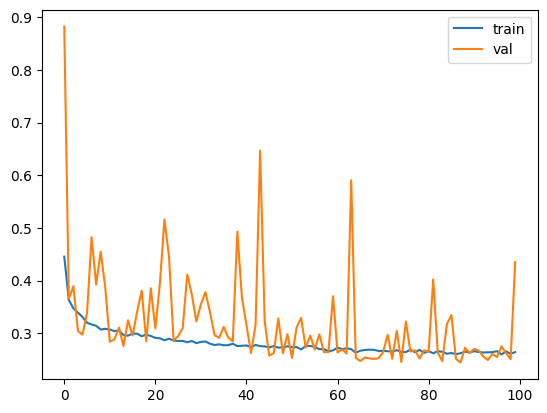

In [23]:
best_model, train_losses, val_losses = train_early_stopping(
    train_loader, val_loader, model, loss_fn, optimizer, epochs=100, early_stopping=True,
    threshold=0.4, patience=10,
    clipping=True)

# plot training and validation losses
plt.figure()
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
plt.legend()
plt.show()


model = best_model

In [24]:
model_save_path = '../../models/display-box/new-models/display-box-2.mdl'

In [25]:
torch.save(model.state_dict(), model_save_path)

In [26]:
model = DeepLocation8(height=4, width=4, num_bins=16, out_dims=3).to(device)
model.load_state_dict(torch.load(model_save_path))

/var/folders/3c/gwjrml9d76v_zwbyb2x6yc0r0000gn/T/ipykernel_28881/163121519.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_save_pa

<All keys matched successfully>

In [27]:
# Out of sample test
model.eval()
# test(test_loader, model, loss_fn)
test(test_loader, model, loss_fn)

Test Error: 
 Accuracy: 58.3%, Avg loss: 0.419163 



0.4191634839716049

In [28]:
for i in range(20):
    # Get a single example from the test dataset
    example_data, example_label = test_dataset[i]
    example_label = example_label.to(device)

    # Move the example data to the appropriate device
    example_data = example_data.unsqueeze(0).to(device)

    # Set the model to evaluation mode
    model.eval()

    # Get the model's prediction
    with torch.no_grad():
        example_data = example_data.to(device)
        output = model(example_data).squeeze()

    print(f'Prediction: {output}, Actual label: {example_label}, Distance: {torch.norm(output - example_label):.4f}')

Prediction: tensor([-7.2343,  2.0408, -1.6869], device='mps:0'), Actual label: tensor([0., 1., 0.], device='mps:0'), Distance: 7.5009
Prediction: tensor([-6.0790, -6.2913,  6.0009], device='mps:0'), Actual label: tensor([0., 0., 1.], device='mps:0'), Distance: 10.0769
Prediction: tensor([-0.5481, -3.6891, -5.1856], device='mps:0'), Actual label: tensor([0., 0., 0.], device='mps:0'), Distance: 6.3875
Prediction: tensor([-8.8596, -5.7811,  6.2010], device='mps:0'), Actual label: tensor([0., 0., 1.], device='mps:0'), Distance: 11.7883
Prediction: tensor([-2.1193, -0.7145, -1.6827], device='mps:0'), Actual label: tensor([0., 0., 0.], device='mps:0'), Distance: 2.7988
Prediction: tensor([-1.0909, -2.6031, -1.5342], device='mps:0'), Actual label: tensor([0., 0., 0.], device='mps:0'), Distance: 3.2125
Prediction: tensor([-9.2558, -5.9472,  6.7053], device='mps:0'), Actual label: tensor([0., 0., 1.], device='mps:0'), Distance: 12.3931
Prediction: tensor([-7.2682, -1.7997,  2.2150], device='mps

## External testing set

In [37]:
dataset_path = "../../datasets/classification-demo/mini_2/zero_mini.pkl"
dataset_test_0 = HistogramDataset(
    dataset_path,
    rolling_window=1
)
dataset_path = "../../datasets/classification-demo/mini_2/zone_1_mini.pkl"
dataset_test_1 = HistogramDataset(
    dataset_path,
    rolling_window=1
)
dataset_path = "../../datasets/classification-demo/mini_2/zone_2_mini.pkl"
dataset_test_2 = HistogramDataset(
    dataset_path,
    rolling_window=1
)
dataset_path = "../../datasets/classification-demo/mini_2/zone_3_mini.pkl"
dataset_test_3 = HistogramDataset(
    dataset_path,
    rolling_window=1
)

In [36]:
for dataset in [dataset_test_0, dataset_test_1, dataset_test_2, dataset_test_3]:
    dataset.raw_inputs = dataset.raw_inputs[:200]
    dataset.raw_targets = dataset.raw_targets[:200]
    dataset.inputs = dataset.raw_inputs
    dataset.targets = dataset.raw_targets

In [38]:
# represent categorical as (zone_1, zone_2, zone_3) binary
dataset_test_0.raw_targets = torch.full((200, 3), 0, dtype=torch.float32)
dataset_test_1.raw_targets = torch.broadcast_to(torch.tensor([1, 0, 0]), (200, 3)).type(torch.float32)
dataset_test_2.raw_targets = torch.broadcast_to(torch.tensor([0, 1, 0]), (200, 3)).type(torch.float32)
dataset_test_3.raw_targets = torch.broadcast_to(torch.tensor([0, 0, 1]), (200, 3)).type(torch.float32)

In [39]:
external_dataset = dataset_0 + dataset_1 + dataset_2 + dataset_3

In [40]:
external_test_loader = DataLoader(external_dataset, batch_size=batch_size, shuffle=False)

In [41]:
external_test_loader.dataset.inputs.shape

torch.Size([4000, 4, 4, 16])

In [42]:
test(external_test_loader, model, loss_fn)

Test Error: 
 Accuracy: 65.5%, Avg loss: 0.308125 



0.308125231070444

In [43]:
# Set the model to evaluation mode
model.eval()

# Initialize a list to store predictions
predictions = []

# Disable gradient calculation
with torch.no_grad():
    for X, _ in external_test_loader:
        X = X.to(device)
        output = model(X)
        # predicted_classes = output.argmax(dim=1)
        # predictions.extend(predicted_classes.cpu().numpy())
        # predicted_zones = torch.round(torch.clamp(output, min=0, max=1))
        predicted_zones = torch.round(torch.sigmoid(output))
        predictions.extend(predicted_zones.cpu().numpy())

# Convert predictions to a numpy array
y_preds = np.array(predictions)
print(y_preds)

y_test = np.array([y for _, y in external_dataset])

[[1. 0. 0.]
 [0. 0. 0.]
 [0. 0. 1.]
 ...
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]


In [44]:
y_test = np.array([y[0] for _, y in external_dataset]).astype(int)
y_preds = np.array([p[0] for p in predictions]).astype(int)

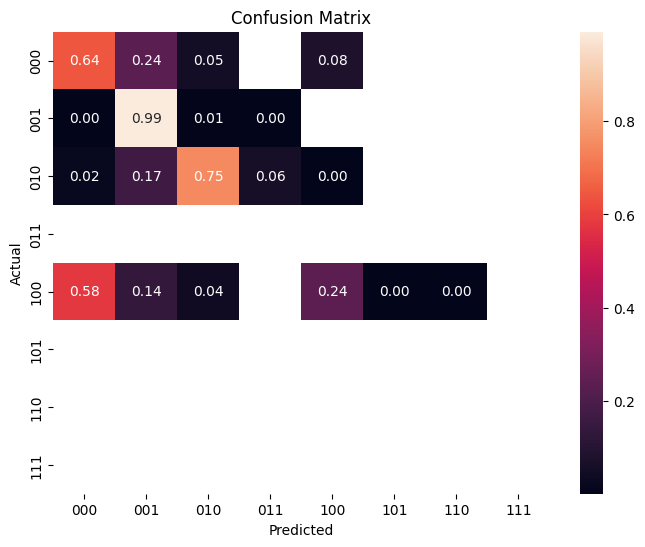

In [45]:
categories = ["000", "001", "010", "011", "100", "101", "110", "111"]

y_test = np.array([y for _, y in external_dataset]).astype(int)
y_preds = np.array([p for p in predictions]).astype(int)

y_test = [''.join(map(str, label)) for label in y_test]
y_preds = [''.join(map(str, label)) for label in y_preds]


# Compute confusion matrix with all possible labels
conf_matrix = confusion_matrix(y_test, y_preds, labels=categories)
row_sums = conf_matrix.sum(axis=1, keepdims=True)
row_sums[row_sums == 0] = 1
conf_matrix_normalized = conf_matrix.astype('float') / row_sums
conf_matrix_normalized[conf_matrix == 0] = np.nan

# Plot the heatmap
plt.figure(figsize=(8,6), dpi=100)
ax = sns.heatmap(conf_matrix_normalized, annot=True, fmt=".2f", mask=np.isnan(conf_matrix_normalized))

# Set tick labels
ax.set_xticks(np.arange(len(categories)) + 0.5)
ax.set_yticks(np.arange(len(categories)) + 0.5)
ax.set_xticklabels(categories)
ax.set_yticklabels(categories)

# Labels and title
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")

plt.show()

In [ ]:
def x_loss(y_pred, y_true):
    return torch.mean(torch.pow(y_pred[:, 0] - y_true[:, 0], 2))

def y_loss(y_pred, y_true):
    return torch.mean(torch.pow(y_pred[:, 1] - y_true[:, 1], 2))

def mse_loss(y_pred, y_true):
    return torch.mean(torch.pow(y_pred - y_true, 2))

In [ ]:
test(external_test_loader, model, x_loss)

In [ ]:
test(external_test_loader, model, y_loss)

In [ ]:
test(external_test_loader, model, mse_loss)

In [ ]:
for i in range(20):
    # Get a single example from the test dataset
    example_data, example_label = test_dataset[i]
    example_label = example_label.to(device)

    # Move the example data to the appropriate device
    example_data = example_data.unsqueeze(0).to(device)

    # Set the model to evaluation mode
    model.eval()

    # Get the model's prediction
    with torch.no_grad():
        example_data = example_data.to(device)
        output = model(example_data).squeeze()

    print(f'Prediction: {output.cpu()}, Actual label: {example_label.cpu()}, Distance: {torch.norm(output - example_label):.4f}')